# RNN

## pseudo code

In [1]:
import numpy as np

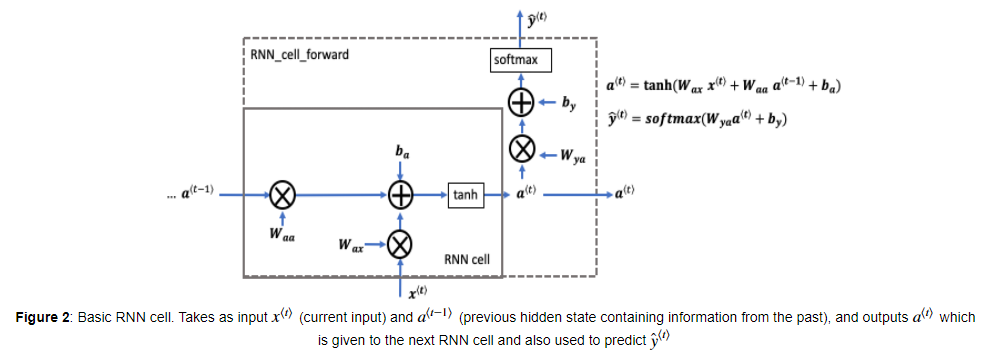

In [2]:
def rnn_cell_forward(xt, h_prev, parameters):
    
    Whx = parameters["Whx"]
    Whh = parameters["Whh"]
    Wyh = parameters["Wyh"]
    bh = parameters["bh"]
    by = parameters["by"]
    
    h_next = np.tanh(np.dot(Whh, h_prev) + np.dot(Whx, xt) + bh)
    y_pred = softmax(np.dot(Wyh, h_next) + by)
    
    cache = (h_next, h_prev, xt, parameters)
    
    return h_next, y_pred, cache

In [3]:
def rnn_forward(x, h0, parameters): # h0: 초기 hidden state
    
    caches = []
    
    n_x, m, T_x = x.shape # n_x: 입력 벡터의 차원, m: 배치 크기, T_x: 시퀀스 길이
    n_y, n_h = parameters["Wyh"].shape # n_y: 출력 벡터의 차원, n_h: hidden state의 차원
    
    # initialize h, y_pred (by zeros) and h_next (by h0)
    h = np.zeros((n_h, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    h_next = h0
    
    for t in range(T_x):
        h_next, y_pred_next, cache = rnn_cell_forward(x[:, :, t], h_next, parameters) # rnn cell forward propagation 계산 실행
        h[:, :, t] = h_next # h_next를 h에 저장
        y_pred[:, :, t] = y_pred_next # y_pred_next를 y_pred에 저장
        caches.append(cache) # cache를 caches에 저장
    
    caches = (caches, x) # caches와 x를 튜플로 묶음
    
    return h, y_pred, caches

In [4]:
def rnn_cell_backward(dh_next, cache):
    
    (h_next, h_prev, xt, parameters) = cache
    
    Whx = parameters["Whx"]
    Whh = parameters["Whh"]
    Wyh = parameters["Wyh"]
    bh = parameters["bh"]
    by = parameters["by"]
    
    dz = dh_next * (1 - np.square(h_next))
    dxt = np.dot(Whx.T, dz)
    dWhx = np.dot(dz, xt.T)
    dh_prev = np.dot(Whh.T, dz)
    dWhh = np.dot(dz, h_prev.T)
    
    dbh = np.sum(dz, axis = -1, keepdims = True)
    
    gradients = {"dxt": dxt, "dh_prev": dh_prev, "dWhx": dWhx, "dWhh": dWhh, "dbh": dbh}
    
    return gradients

In [5]:
def rnn_backward(dh, caches):
    
    (caches, x) = caches
    (h1, h0, x1, parameters) = caches[0]
    
    n_h, m, T_x = dh.shape # n_h: hidden state의 차원, m: 배치 크기, T_x: 시퀀스 길이
    n_x, m = x1.shape # n_x: 입력 벡터의 차원
    
    # initialize dx, dh0, dWhx, dWhh, dbh (by zeros)
    dx = np.zeros((n_x, m, T_x))
    dWhx = np.zeros((n_h, n_x))
    dWhh = np.zeros((n_h, n_h))
    dbh = np.zeros((n_h, 1))
    dh0 = np.zeros((n_h, m))
    dh_prev = np.zeros((n_h, m))
    
    for t in reversed(range(T_x)):
        gradients = rnn_cell_backward(dh[:, :, t] + dh_prev, caches[t]) # rnn cell backward propagation 계산 실행
        dxt, dh_prev, dWhxt, dWhht, dbht = gradients["dxt"], gradients["dh_prev"], gradients["dWhx"], gradients["dWhh"], gradients["dbh"] # gradients에서 dxt, dh_prev, dWhxt, dWhht, dbht를 불러옴
        dx[:, :, t] = dxt # dxt를 dx에 저장
        dWhx += dWhxt
        dWhh += dWhht
        dbh += dbht
        
    dh0 = dh_prev
    
    gradients = {"dx": dx, "dh0": dh0, "dWhx": dWhx, "dWhh": dWhh, "dbh": dbh}
    
    return gradients

## Pytorch

### Import packages, data

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [7]:
input_str = 'apple'
label_str = 'pple!'
char_vocab = sorted(list(set(input_str + label_str)))
vocab_size = len(char_vocab)
print('문자 집합의 종류와 크기 : {}, {}'.format(char_vocab, vocab_size))

문자 집합의 종류와 크기 : ['!', 'a', 'e', 'l', 'p'], 5


In [8]:
input_size = vocab_size
hidden_size = 5
output_size = 5
learning_rate = 0.1

### One-hot encoding(char)

In [9]:
char_to_index = {char : index for index, char in enumerate(char_vocab)}
print('문자 집합 :',char_to_index)

문자 집합 : {'!': 0, 'a': 1, 'e': 2, 'l': 3, 'p': 4}


In [10]:
x_data = [[char_to_index[char] for char in input_str]]
y_data = [[char_to_index[char] for char in label_str]]
print(x_data, y_data)

[[1, 4, 4, 3, 2]] [[4, 4, 3, 2, 0]]


In [11]:
def one_hot_encoding(char, char_to_index):
    one_hot_vector = [0]*(len(char_to_index))
    index = char_to_index[char]
    one_hot_vector[index] = 1
    return one_hot_vector

In [12]:
x_one_hot = [[one_hot_encoding(char, char_to_index) for char in input_str]]

In [13]:
X = torch.FloatTensor(x_one_hot)
Y = torch.LongTensor(y_data)

print('훈련, 레이블의 크기: {}, {}'.format(X.shape, Y.shape))

훈련, 레이블의 크기: torch.Size([1, 5, 5]), torch.Size([1, 5])


### Model

In [14]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size, bias=True)
    
    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x)
        return x

In [15]:
rnn_net = Net(input_size, hidden_size, output_size)

In [16]:
outputs = rnn_net(X)
print(outputs.shape)

torch.Size([1, 5, 5])


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_net.parameters(), lr=learning_rate)

In [18]:
for i in range(100):
    optimizer.zero_grad()
    outputs = rnn_net(X)
    loss = criterion(outputs.view(-1, vocab_size), Y.view(-1)) # view()를 통해 batch 차원을 제거
    loss.backward()
    optimizer.step()
    
    result = outputs.data.numpy().argmax(axis=2) # 예측값
    result_str = ''.join([char_vocab[c] for c in np.squeeze(result)]) # 예측값을 문자열로 변환
    print(i, "loss: ", loss.item(), "prediction: ", result, "true Y: ", y_data, "prediction str: ", result_str)

0 loss:  1.6383033990859985 prediction:  [[3 3 3 3 3]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  lllll
1 loss:  1.3917768001556396 prediction:  [[4 3 3 3 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  plll!
2 loss:  1.1895862817764282 prediction:  [[0 4 0 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  !p!e!
3 loss:  1.0178407430648804 prediction:  [[0 4 0 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  !p!e!
4 loss:  0.8414654731750488 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
5 loss:  0.669764518737793 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
6 loss:  0.5333052277565002 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
7 loss:  0.4143156409263611 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
8 loss:  0.3191124498844147 prediction:  [[4 4 3 2 0]] true Y:  [[4, 4, 3, 2, 0]] prediction str:  pple!
9 loss:  0.2463696300983429 prediction:  [[4 4 3 2 0]] t